<a href="https://www.kaggle.com/code/yorkyong/s4e11-depression-prediction-ensemble?scriptVersionId=205128069" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import optuna

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer


# Load dataset

In [159]:
train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv',index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv',index_col='id')
submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv',index_col='id')

In [160]:
train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [161]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  float

In [162]:
test.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,
140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [163]:
submission.head()

,Depression
id,
140700,0
140701,0
140702,0
140703,0
140704,0


# Data Preprocesing

In [164]:
# Check for duplicates by id and row
duplicates_id = train.index.duplicated().sum()
duplicates_rows = train.duplicated().sum()
print(f"Duplicate IDs: {duplicates_id}")
print(f"Duplicate Rows: {duplicates_rows}")

Duplicate IDs: 0
Duplicate Rows: 0


In [165]:
# Drop unnecessary columns
train.drop(['Name','City'], axis=1, inplace=True)
test.drop(['Name','City'], axis=1, inplace=True)

In [166]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  object 
 1   Age                                    140700 non-null  float64
 2   Working Professional or Student        140700 non-null  object 
 3   Profession                             104070 non-null  object 
 4   Academic Pressure                      27897 non-null   float64
 5   Work Pressure                          112782 non-null  float64
 6   CGPA                                   27898 non-null   float64
 7   Study Satisfaction                     27897 non-null   float64
 8   Job Satisfaction                       112790 non-null  float64
 9   Sleep Duration                         140700 non-null  object 
 10  Dietary Habits                         140696 non-null  objec

In [167]:
# Display unique values for each object column
object_cols = train.select_dtypes(include=['object']).columns

# Dictionary to store unique values for each object column
unique_values_dict = {}

for col in object_cols:
    unique_values = train[col].unique()
    unique_count = len(unique_values)
    
    # Store unique values and their count for review
    unique_values_dict[col] = {'Unique Count': unique_count, 'Unique Values': unique_values[:20]}  # show up to 20 unique values for brevity

# Display results for inspection
for col, data in unique_values_dict.items():
    print(f"Column: {col}")
    print(f"Unique Count: {data['Unique Count']}")
    print(f"Sample Unique Values: {data['Unique Values']}\n")


Column: Gender
Unique Count: 2
Sample Unique Values: ['Female' 'Male']

Column: Working Professional or Student
Unique Count: 2
Sample Unique Values: ['Working Professional' 'Student']

Column: Profession
Unique Count: 65
Sample Unique Values: ['Chef' 'Teacher' nan 'Business Analyst' 'Finanancial Analyst' 'Chemist'
 'Electrician' 'Software Engineer' 'Data Scientist' 'Plumber'
 'Marketing Manager' 'Accountant' 'Entrepreneur' 'HR Manager'
 'UX/UI Designer' 'Content Writer' 'Educational Consultant'
 'Civil Engineer' 'Manager' 'Pharmacist']

Column: Sleep Duration
Unique Count: 36
Sample Unique Values: ['More than 8 hours' 'Less than 5 hours' '5-6 hours' '7-8 hours'
 'Sleep_Duration' '1-2 hours' '6-8 hours' '4-6 hours' '6-7 hours'
 '10-11 hours' '8-9 hours' '40-45 hours' '9-11 hours' '2-3 hours'
 '3-4 hours' 'Moderate' '55-66 hours' '4-5 hours' '9-6 hours' '1-3 hours']

Column: Dietary Habits
Unique Count: 24
Sample Unique Values: ['Healthy' 'Unhealthy' 'Moderate' 'Yes' 'Pratham' 'BSc' 'Ge

In [168]:
# Display unique values for each object column
object_cols = test.select_dtypes(include=['object']).columns

# Dictionary to store unique values for each object column
unique_values_dict = {}

for col in object_cols:
    unique_values = test[col].unique()
    unique_count = len(unique_values)
    
    # Store unique values and their count for review
    unique_values_dict[col] = {'Unique Count': unique_count, 'Unique Values': unique_values[:20]}  # show up to 20 unique values for brevity

# Display results for inspection
for col, data in unique_values_dict.items():
    print(f"Column: {col}")
    print(f"Unique Count: {data['Unique Count']}")
    print(f"Sample Unique Values: {data['Unique Values']}\n")


Column: Gender
Unique Count: 2
Sample Unique Values: ['Male' 'Female']

Column: Working Professional or Student
Unique Count: 2
Sample Unique Values: ['Working Professional' 'Student']

Column: Profession
Unique Count: 65
Sample Unique Values: ['Judge' 'Educational Consultant' 'Teacher' nan 'Customer Support'
 'Chemist' 'Content Writer' 'Consultant' 'HR Manager' 'Research Analyst'
 'Digital Marketer' 'Electrician' 'Marketing Manager' 'Plumber'
 'Pharmacist' 'Lawyer' 'Pilot' 'Architect' 'Chef' 'Graphic Designer']

Column: Sleep Duration
Unique Count: 31
Sample Unique Values: ['Less than 5 hours' '7-8 hours' 'More than 8 hours' '5-6 hours' '0'
 'Meerut' '9-5 hours' '6-7 hours' '60-65 hours' 'Vivan' '3-4 hours'
 '1-6 hours' '9-5' 'Unhealthy' '8-9 hours' '4-5 hours' 'than 5 hours'
 '9-6 hours' '1-2 hours' '8-89 hours']

Column: Dietary Habits
Unique Count: 23
Sample Unique Values: ['Moderate' 'Healthy' 'Unhealthy' 'More Healthy' 'No' 'Indoor' 'Prachi'
 nan 'Male' 'Less Healthy' 'Mealy' 'Re

In [169]:
# Define mappings for Dietary Habits
dietary_mapping = {
    'Healthy': 'Healthy', 
    'More Healthy': 'Healthy', 
    'Less Healthy': 'Unhealthy', 
    '5 Healthy': 'Healthy',
    'Unhealthy': 'Unhealthy', 
    'Moderate': 'Moderate'
}

# Define mapping for Sleep Duration categories
sleep_duration_mapping = {
    'Less than 5 hours': 'Very Short',
    '1-2 hours': 'Very Short',
    '2-3 hours': 'Very Short',
    '3-4 hours': 'Very Short',
    '4-5 hours': 'Very Short',
    '5-6 hours': 'Short',
    '6-7 hours': 'Moderate',
    '7-8 hours': 'Moderate',
    '8-9 hours': 'Long',
    'More than 8 hours': 'Long',
    '9-11 hours': 'Very Long',
    '10-11 hours': 'Very Long',
    '40-45 hours': np.nan,
    '55-66 hours': np.nan,
    '60-65 hours': np.nan,
    '8-89 hours': np.nan,
    '9-5 hours': np.nan,
    '1-6 hours': np.nan,
    '9-6 hours': np.nan
}

# Function to clean Dietary Habits and map Sleep Duration
def clean_and_map_columns(df):
    # Map Dietary Habits
    df['Dietary Habits'] = df['Dietary Habits'].apply(
        lambda x: dietary_mapping.get(x, np.nan) if isinstance(x, str) else np.nan
    )
    
    # Map Sleep Duration based on defined categories
    df['Sleep Duration'] = df['Sleep Duration'].apply(
        lambda x: sleep_duration_mapping.get(x, np.nan) if isinstance(x, str) else np.nan
    )

# Apply cleaning and mapping to both train and test sets
for df in [train, test]:
    clean_and_map_columns(df)

# Verify results after cleaning and mapping
print("Unique values in 'Dietary Habits' after cleaning:")
print("Train set:", train['Dietary Habits'].unique())
print("Test set:", test['Dietary Habits'].unique())
print("\nUnique values in 'Sleep Duration' after mapping:")
print("Train set:", train['Sleep Duration'].unique())
print("Test set:", test['Sleep Duration'].unique())


Unique values in 'Dietary Habits' after cleaning:
Train set: ['Healthy' 'Unhealthy' 'Moderate' nan]
Test set: ['Moderate' 'Healthy' 'Unhealthy' nan]

Unique values in 'Sleep Duration' after mapping:
Train set: ['Long' 'Very Short' 'Short' 'Moderate' nan 'Very Long']
Test set: ['Very Short' 'Moderate' 'Long' 'Short' nan 'Very Long']


In [170]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  object 
 1   Age                                    140700 non-null  float64
 2   Working Professional or Student        140700 non-null  object 
 3   Profession                             104070 non-null  object 
 4   Academic Pressure                      27897 non-null   float64
 5   Work Pressure                          112782 non-null  float64
 6   CGPA                                   27898 non-null   float64
 7   Study Satisfaction                     27897 non-null   float64
 8   Job Satisfaction                       112790 non-null  float64
 9   Sleep Duration                         140660 non-null  object 
 10  Dietary Habits                         140676 non-null  objec

# Pipeline with Feature Engineering

In [171]:
# # Define categorical and numerical columns
# categorical_cols = ['Gender', 'Working Professional or Student', 'Profession', 'Sleep Duration', 
#                     'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 
#                     'Family History of Mental Illness']
# numerical_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 
#                   'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']


# # Define preprocessing for categorical features using OrdinalEncoder
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
# ])

# # Define preprocessing for numerical features
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', RobustScaler())
# ])

# # Combine preprocessing steps and add feature engineering
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ],
#     remainder='passthrough'
# )

# # Set output to pandas for the ColumnTransformer
# preprocessor.set_output(transform="pandas")

# # Define the full pipeline including feature engineering
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ])

# # Set output to pandas for the entire pipeline
# pipeline.set_output(transform="pandas")

# # Apply pipeline on X (train) and transform test data as well
# X = train.drop('Depression', axis=1)
# y = train['Depression']
# X_preprocessed = pipeline.fit_transform(X)
# test_preprocessed = pipeline.transform(test)

# # Verify processed data
# X_preprocessed.head()


,num__Age,num__Academic Pressure,num__Work Pressure,num__CGPA,num__Study Satisfaction,num__Job Satisfaction,num__Work/Study Hours,num__Financial Stress,cat__Gender,cat__Working Professional or Student,cat__Profession,cat__Sleep Duration,cat__Dietary Habits,cat__Degree,cat__Have you ever had suicidal thoughts ?,cat__Family History of Mental Illness
id,,,,,,,,,,,,,,,,
0,0.318182,0.0,1.0,0.0,0.0,-0.5,-0.714286,-0.5,0.0,1.0,10.0,0.0,0.0,33.0,0.0,0.0
1,-0.727273,0.0,0.5,0.0,0.0,0.0,0.142857,0.0,1.0,1.0,55.0,4.0,2.0,63.0,1.0,0.0
2,-0.409091,2.0,0.0,1.2,-1.0,0.0,-0.428571,-1.0,1.0,0.0,55.0,2.0,0.0,21.0,1.0,0.0
3,-0.909091,0.0,1.0,0.0,0.0,-1.0,0.571429,-1.0,1.0,1.0,55.0,4.0,1.0,28.0,1.0,1.0
4,-0.545455,0.0,-1.0,0.0,0.0,-1.0,0.428571,0.5,0.0,1.0,9.0,2.0,2.0,28.0,1.0,1.0


In [185]:
# Columns with no missing data (based on your data description)
categorical_cols_no_missing = ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 
                               'Family History of Mental Illness']
numerical_cols_no_missing = ['Age', 'Work/Study Hours']

# Columns with potential missing data (for preprocessing only, not feature engineering)
categorical_cols_with_missing = ['Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']
numerical_cols_with_missing = ['Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 
                               'Job Satisfaction', 'Financial Stress']


def bin_features(X):
    X_copy = X.copy()
    # Update to use the prefixed column names
    if 'num_Age' in X_copy.columns:
        X_copy['Age_Group'] = pd.cut(X_copy['num_Age'], bins=[0, 20, 30, 40, 50, 60, 100], labels=False)
    if 'num_Work/Study Hours' in X_copy.columns:
        X_copy['Work_Hours_Binned'] = pd.cut(X_copy['num_Work/Study Hours'], bins=[0, 5, 8, 24], labels=[0, 1, 2])
    return X_copy

def aggregate_features(X):
    X_copy = X.copy()
    # Update to use the prefixed column names
    satisfaction_cols = ['num_Study Satisfaction', 'num_Job Satisfaction']
    stress_cols = ['num_Financial Stress', 'num_Work Pressure', 'num_Academic Pressure']
    
    # Only proceed if all necessary columns are present
    if all(col in X_copy.columns for col in satisfaction_cols):
        X_copy['Overall_Satisfaction'] = X_copy[satisfaction_cols].mean(axis=1)
    if all(col in X_copy.columns for col in stress_cols):
        X_copy['Overall_Stress'] = X_copy[stress_cols].mean(axis=1)
    
    return X_copy


# Define categorical and numerical transformers (no change)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Combine preprocessing steps with feature engineering
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_no_missing + numerical_cols_with_missing),
        ('cat', categorical_transformer, categorical_cols_no_missing + categorical_cols_with_missing)
    ],
    remainder='passthrough'
)

# Set output to pandas for the ColumnTransformer
preprocessor.set_output(transform="pandas")

# Define the full pipeline including feature engineering steps
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('bin_features', FunctionTransformer(bin_features, validate=False)),
    ('aggregate_features', FunctionTransformer(aggregate_features, validate=False))
])

# Set output to pandas for the entire pipeline
pipeline.set_output(transform="pandas")

# Apply pipeline on X (train) and transform test data as well
X = train.drop('Depression', axis=1)
y = train['Depression']
X_preprocessed = pipeline.fit_transform(X)
test_preprocessed = pipeline.transform(test)

# Verify processed data
X_preprocessed.head()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,num__Age,num__Work/Study Hours,num__Academic Pressure,num__Work Pressure,num__CGPA,num__Study Satisfaction,num__Job Satisfaction,num__Financial Stress,cat__Gender,cat__Working Professional or Student,cat__Have you ever had suicidal thoughts ?,cat__Family History of Mental Illness,cat__Profession,cat__Sleep Duration,cat__Dietary Habits,cat__Degree
id,,,,,,,,,,,,,,,,
0,0.318182,-0.714286,0.0,1.0,0.0,0.0,-0.5,-0.5,0.0,1.0,0.0,0.0,10.0,0.0,0.0,33.0
1,-0.727273,0.142857,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,55.0,4.0,2.0,63.0
2,-0.409091,-0.428571,2.0,0.0,1.2,-1.0,0.0,-1.0,1.0,0.0,1.0,0.0,55.0,2.0,0.0,21.0
3,-0.909091,0.571429,0.0,1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,1.0,1.0,55.0,4.0,1.0,28.0
4,-0.545455,0.428571,0.0,-1.0,0.0,0.0,-1.0,0.5,0.0,1.0,1.0,1.0,9.0,2.0,2.0,28.0


# Modelling and HPO with Optuna

In [186]:
# Define objective functions for each model's hyperparameter tuning
def optimize_xgb(trial):
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    
   
    # Cross-validation with stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    scores = cross_val_score(model, X_preprocessed, y, cv=skf, scoring='accuracy')
    return np.mean(scores)

def optimize_cat(trial):
    # Define hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255)
    }
    model = CatBoostClassifier(**params, verbose=0)
    
   
    # Cross-validation with stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    scores = cross_val_score(model, X_preprocessed, y, cv=skf, scoring='accuracy')
    return np.mean(scores)

def optimize_lgbm(trial):
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }
    model = LGBMClassifier(**params, verbose=-1)
    
    
    # Cross-validation with stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    scores = cross_val_score(model, X_preprocessed, y, cv=skf, scoring='accuracy')
    return np.mean(scores)

In [187]:
# Optimize hyperparameters using Optuna
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(optimize_xgb, n_trials=30)

cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(optimize_cat, n_trials=30)

lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(optimize_lgbm, n_trials=30)

[I 2024-11-04 05:16:18,527] A new study created in memory with name: no-name-a010cdc0-7da6-4a5d-aff6-1b3db4f5dce3
[I 2024-11-04 05:16:52,590] Trial 0 finished with value: 0.9328571428571429 and parameters: {'n_estimators': 224, 'max_depth': 7, 'learning_rate': 0.28035937377467696, 'subsample': 0.7439496075035659, 'colsample_bytree': 0.8002754955091604}. Best is trial 0 with value: 0.9328571428571429.
[I 2024-11-04 05:17:36,957] Trial 1 finished with value: 0.9390262970859986 and parameters: {'n_estimators': 438, 'max_depth': 4, 'learning_rate': 0.1243809983539056, 'subsample': 0.8436809192643488, 'colsample_bytree': 0.6902400737538064}. Best is trial 1 with value: 0.9390262970859986.
[I 2024-11-04 05:18:11,793] Trial 2 finished with value: 0.9355650319829424 and parameters: {'n_estimators': 352, 'max_depth': 3, 'learning_rate': 0.01762510779752356, 'subsample': 0.7531077823457014, 'colsample_bytree': 0.6754664252206373}. Best is trial 1 with value: 0.9390262970859986.
[I 2024-11-04 05:

# Ensemble Model and check Stratified Kfold score

In [188]:
# Retrieve best models
xgb_best = XGBClassifier(**xgb_study.best_params, use_label_encoder=False, eval_metric='logloss')
cat_best = CatBoostClassifier(**cat_study.best_params, verbose=0)
lgbm_best = LGBMClassifier(**lgbm_study.best_params, verbose=-1)

In [189]:
# Ensemble model
ensemble = VotingClassifier(
    estimators=[('xgb', xgb_best), ('cat', cat_best), ('lgbm', lgbm_best)],
    voting='hard'  # Use hard voting since the output is binary (0, 1)
)

# Stratified K-Fold for accuracy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble, X_preprocessed, y, cv=skf, scoring='accuracy')
print("Cross-Validation Accuracy Scores: ", cv_scores)
print("Mean CV Accuracy Score: ", np.mean(cv_scores))

# Fit ensemble on the full training data
ensemble.fit(X_preprocessed, y)

Cross-Validation Accuracy Scores:  [0.93941009 0.9380597  0.94061834 0.94093817 0.93919687]
Mean CV Accuracy Score:  0.9396446339729924


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5598434018153423,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrain...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=268, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7eda84c92380>),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.05245131794583378,
                                             min_child_samples=8,
                                             n_estimators=199, num_leaves=33,
                                             subsample=0.7595351922761258,
                                             verbose=-1))])

# Submission

In [190]:
# Predict on test data
test_predictions = ensemble.predict(test_preprocessed)

# Save predictions to DataFrame
submission['Depression'] = test_predictions
submission.to_csv('submission_ensemble.csv') 

In [191]:
submission

,Depression
id,
140700,0
140701,0
140702,0
140703,1
140704,0
...,...
234495,0
234496,1
234497,0


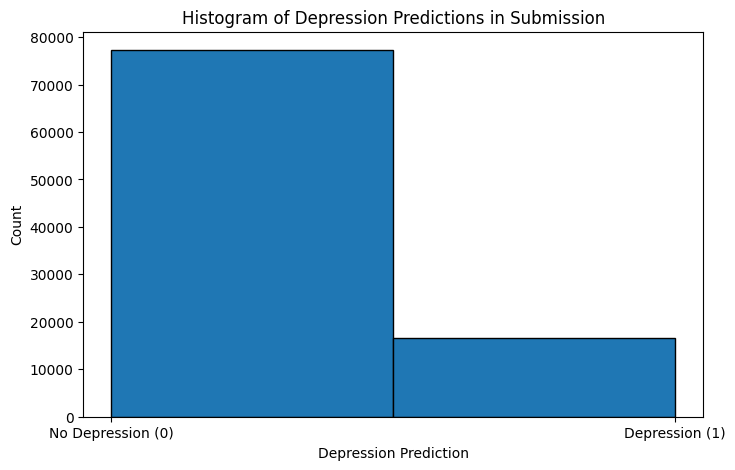

In [192]:
import matplotlib.pyplot as plt

# Plot histogram of the Depression counts in the submission
plt.figure(figsize=(8, 5))
plt.hist(submission['Depression'], bins=2, edgecolor='black')
plt.xticks([0, 1], ['No Depression (0)', 'Depression (1)'])
plt.xlabel('Depression Prediction')
plt.ylabel('Count')
plt.title('Histogram of Depression Predictions in Submission')
plt.show()